# This code is to get the labeled_energy_data csv file of each model

## 对数据进行分析,展示出来的内容包括:
### 1. 每个模型在 5 个 epochs 下的每个能耗数据点

# Import the lib

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Function in use

## load the interpolate function

In [32]:
def integrate_power_over_interval(samples, start_time, end_time):
    # 假定 samples是按时间升序排序的 (t, p)
    # 若未排序，请先排序:
    # samples = sorted(samples, key=lambda x: x[0])
    
    def interpolate(samples, target_time):
        # 在 samples 中找到 target_time 左右最近的两个点，并进行线性插值
        # 若 target_time 恰好等于某个样本点时间，直接返回该点功率
        # 若无法找到两侧点（如 target_time在样本时间轴外），根据情况返回None或边界点
        n = len(samples)
        if n == 0:
            return None
        # 若 target_time 小于第一个样本点时间，无法向左插值，这里直接返回第一个点的功率值(或None)
        if target_time <= samples[0][0]:
            # 简化处理：返回最早样本点的功率（或None）
            return samples[0][1]
        # 若 target_time 大于最后一个样本点时间，无法向右插值，返回最后一个点的功率（或None）
        if target_time >= samples[-1][0]:
            return samples[-1][1]

        # 否则，在中间插值
        # 使用二分查找快速定位
        import bisect
        times = [t for t, _ in samples]
        pos = bisect.bisect_left(times, target_time)
        # pos是使times保持有序插入target_time的位置
        # 因为target_time不在已有样本点中，pos不会越界且pos>0且pos<n
        t1, p1 = samples[pos-1]
        t2, p2 = samples[pos]
        # 线性插值： p = p1 + (p2 - p1)*((target_time - t1)/(t2 - t1))
        ratio = (target_time - t1) / (t2 - t1)
        p = p1 + (p2 - p1)*ratio
        return p

    # 从原始 samples 中筛选出位于[start_time, end_time]内的点
    filtered = [(t, p) for t, p in samples if start_time <= t <= end_time]

    # 如果不足2个点，则尝试使用插值
    if len(filtered) < 2:
        # 无论如何都需要在边界处插值出两个点(起码start和end)
        start_power = interpolate(samples, start_time)
        end_power = interpolate(samples, end_time)

        # 如果从样本中无法插值出任何有意义的点（比如samples为空或无法插值），返回0.0
        if start_power is None or end_power is None:
            return 0.0

        # 将插值的边界点加入到 filtered
        # 注意：如果filtered中有一个点在区间内，我们也需要确保边界有两点以上
        # 例如filtered只有一个点在中间，则需要在start和end插值点全部加入。
        # 若filtered为空，则只用start/end两点插值点求积分
        new_filtered = [(start_time, start_power)] + filtered + [(end_time, end_power)]
        # 确保按时间排序
        new_filtered.sort(key=lambda x: x[0])
        filtered = new_filtered

    # 正常积分计算
    if len(filtered) < 2:
        # 经过插值仍不够，返回0
        return 0.0

    total_energy = 0.0
    for i in range(len(filtered)-1):
        t1, p1 = filtered[i]
        t2, p2 = filtered[i+1]
        dt = t2 - t1
        avg_p = (p1 + p2)/2.0
        total_energy += avg_p * dt

    return total_energy

## Read the data

In [33]:
def load_data(model_path):
    # load the csv files 
    energy_data = pd.read_csv(os.path.join(model_path, 'energy_consumption_file.csv'))
    labeled_energy_data = pd.read_csv(os.path.join(model_path, 'labeled_energy_data.csv'))
    forward_layer_energy = pd.read_csv(os.path.join(model_path, 'layer_energy.csv'))

    # load the npy files
    to_device = np.load(os.path.join(model_path, 'to_device.npy'), allow_pickle=True)
    loss = np.load(os.path.join(model_path, 'loss.npy'), allow_pickle=True)
    backward = np.load(os.path.join(model_path, 'backward.npy'), allow_pickle=True)
    optimize = np.load(os.path.join(model_path, 'optimize.npy'), allow_pickle=True)

    # load the energy data
    to_device_energy = np.load(os.path.join(model_path, 'to_device_energy.npy'), allow_pickle=True)
    forward_energy = np.load(os.path.join(model_path, 'forward_energy.npy'), allow_pickle=True)
    loss_energy = np.load(os.path.join(model_path, 'loss_energy.npy'), allow_pickle=True)
    backward_energy = np.load(os.path.join(model_path, 'backward_energy.npy'), allow_pickle=True)
    optimize_energy = np.load(os.path.join(model_path, 'optimize_energy.npy'), allow_pickle=True)
    
    return energy_data, labeled_energy_data, forward_layer_energy, \
            to_device, loss, backward, optimize, \
            to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy

## Plot functions

### preprocess the data

In [34]:
'''1. get the energy consumption of each layer as well as the forward step energy'''
# get the layer energy consumption into a ndarray
def get_layer_energy(forward_layer_energy, model_path):

    # get the layer names as a list
    # find out the layer names from a batch
    layer_data = forward_layer_energy.iloc[0][0]
    # transfer the string to a dictionary
    layer_data_dic = eval(layer_data)
    # get the layer names
    layer_names = layer_data_dic.keys()
    # transfer the layer names to a list
    layer_names = list(layer_names)
    print('layer_names:', layer_names)

    # print the shape of the forward_layer_energy
    print('The shape of the forward_layer_energy:', forward_layer_energy.shape[0], forward_layer_energy.shape[1])

    # create a ndarray to store the layer energy, the shape is (num_batches_total, num_layers)
    layer_energy = np.zeros((forward_layer_energy.shape[0]* forward_layer_energy.shape[1], len(layer_names)))
    print('The shape of the layer_energy:', layer_energy.shape)

    # # create a ndarray to store the forward step energy, the shape is (num_batches_total, 3)
    # # the first is the forward start time, the second is the forward end time, the third is the forward energy
    # forward_energy = np.zeros((forward_layer_energy.shape[0]* forward_layer_energy.shape[1], 3))
    # print('The shape of the layer_energy:', forward_energy.shape)

    # iterate the column of the csv file, which is the epoch number
    for i in range(forward_layer_energy.shape[1]):
        # iterate the row of the csv file, which is the batch number
        for j in range(forward_layer_energy.shape[0]):
            batch_layer = forward_layer_energy.iloc[j][str(i)]
            batch_layer = eval(batch_layer)
            # print(f'The batch number is {j}, the epoch number is {i}')
            # print(batch_layer)
            # get the first dictionary value of the batch_layer
            # forward_start_time = list(batch_layer.values())[0][0]
            # get the last dictionary value of the batch_layer
            # forward_end_time = list(batch_layer.values())[-1][1]
            # forward_energy_batch = 0
            for layer_name, layer_energy_value in batch_layer.items():
                layer_idx = list(layer_names).index(layer_name)
                row_num = i*forward_layer_energy.shape[0]+j
                # print(f'The row number is {row_num}, the layer index is {layer_idx}')
                layer_energy[row_num, layer_idx] = layer_energy_value[-1]
                # forward_energy_batch += layer_energy_value[-1]
            # forward_energy[i*forward_layer_energy.shape[0]+j, 0] = forward_start_time
            # forward_energy[i*forward_layer_energy.shape[0]+j, 1] = forward_end_time
            # forward_energy[i*forward_layer_energy.shape[0]+j, 2] = forward_energy_batch

    # # transfer the shape of the forward_energy to (num_of_epochs, num_of_batches, 3)
    # forward_energy = forward_energy.reshape((forward_layer_energy.shape[1], forward_layer_energy.shape[0], 3))
    # print('The shape of the layer_energy:', forward_energy.shape)
    
    # # save the forward energy to a npy file, the path is model_path
    # np.save(os.path.join(model_path, 'forward_energy.npy'), forward_energy)

    
    # return layer_names, layer_energy, forward_energy
    return layer_names, layer_energy 

### preset the color and marker

In [35]:
# Create a color map and marker map for the steps
step_colors = {
    'idle': 'gray',
    'to_device': 'blue',
    'forward': 'green',
    'loss': 'red',
    'backward': 'purple',
    'optimize': 'orange'
}
step_markers = {
    'idle': 'o',
    'to_device': 's',
    'forward': '^',
    'loss': 'D',
    'backward': 'x',
    'optimize': 'P'
}

### Plot the energy data of each sample with scatter plot and line plot

In [36]:
def plot_energy_data(labeled_energy_data):
    # Plot the data with a larger figure size
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each step with a different marker
    for step in step_colors.keys():
        step_data = labeled_energy_data[labeled_energy_data['step'] == step]
        if step != 'idle':
            ax.scatter(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step, s=5, marker=step_markers[step])

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Power in Watts')
    ax.legend()
    plt.show()

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(12,6))

    # Plot each step with a different color
    for step in step_colors.keys():
        step_data = labeled_energy_data[labeled_energy_data['step'] == step]
        if step != 'idle':
            ax.plot(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step)

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Power in Watts')
    ax.legend()
    plt.show()

### Plot the energy data of a time period with scatter plot

In [37]:
def plot_period_energy_data(labeled_energy_data):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(12,8))

    labeled_energy_data_rows = labeled_energy_data[4100:4300]
    # Plot each step with a different color, except 'optimize' and 'loss'
    for step in step_colors.keys():
        if step != 'idle':
            if step not in ['optimize', 'loss']:
                step_data = labeled_energy_data_rows[labeled_energy_data_rows['step'] == step]
                ax.scatter(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step)

    # Plot 'optimize' and 'loss' steps last to ensure they are on top
    for step in ['optimize', 'loss']:
        step_data = labeled_energy_data_rows[labeled_energy_data_rows['step'] == step]
        ax.scatter(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step)

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Power in Watts')
    ax.legend()
    plt.show()

### plot each step energy data in each batch

In [38]:
def plot_batch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    batch_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
    energy_data_dict = {
        'to_device': to_device_energy,
        'forward': forward_energy,
        'loss': loss_energy,
        'backward': backward_energy,
        'optimize': optimize_energy
    }

    # print out the shape of the energy_consumption
    print('The shape of the to_device_energy:', to_device_energy.shape)
    print('The shape of the forward_energy:', forward_energy.shape)
    print('The shape of the loss_energy:', loss_energy.shape)
    print('The shape of the backward_energy:', backward_energy.shape)
    print('The shape of the optimize_energy:', optimize_energy.shape)

    # plot the energy consumption for each step
    fig, ax = plt.subplots(figsize=(10,6))
    for step in batch_info:
        energy_data = energy_data_dict[step]
        energy_consumption = [energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]
        ax.plot(range(len(energy_consumption)), energy_consumption, color=step_colors[step], label=step)

    ax.set_xlabel('Batch Index(Total 5 Epochs)')
    ax.set_ylabel('Energy Consumption per batch in Joules')
    ax.legend()
    plt.show()

### plot each step energy data with all batch with the x axis set to each step

In [39]:
def plot_step_energy_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    batch_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
    energy_data_dict = {
        'to_device': to_device_energy,
        'forward': forward_energy,
        'loss': loss_energy,
        'backward': backward_energy,
        'optimize': optimize_energy
    }

    # plot the energy consumption for each step using dots
    fig, ax = plt.subplots(figsize=(10, 6))

    # Calculate the average energy consumption for each step
    average_energy_consumption = {step: np.mean([energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]) for step, energy_data in energy_data_dict.items()}

    # Plot each step's energy consumption as a dot on the corresponding x-axis
    for i, step in enumerate(batch_info):
        energy_data = energy_data_dict[step]
        energy_consumption = [energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]
        ax.scatter([i] * len(energy_consumption), energy_consumption, color=step_colors[step], label=step, marker='o')

    # Set the x-axis labels to the batch_info
    ax.set_xticks(range(len(batch_info)))
    ax.set_xticklabels(batch_info)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Energy Consumption per batch in Joules')
    ax.legend()
    plt.show()

### plot each step mean and std energy data with all batch with the x axis set to each step

In [40]:
def plot_step_energy_distribution_bar(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    # Use a more subtle color palette
    step_colors = {
        'idle': '#999999',  # light gray
        'to_device': '#1f77b4',  # muted blue
        'forward': '#2ca02c',  # muted green
        'loss': '#d62728',  # muted red
        'backward': '#9467bd',  # muted purple
        'optimize': '#ff7f0e'  # muted orange
    }

    energy_data_dict = {
        'to_device': to_device_energy,
        'forward': forward_energy,
        'loss': loss_energy,
        'backward': backward_energy,
        'optimize': optimize_energy
    }

    # Calculate the mean and standard deviation for each step
    mean_energy_consumption = {step: np.mean([energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]) for step, energy_data in energy_data_dict.items()}
    std_energy_consumption = {step: np.std([energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]) for step, energy_data in energy_data_dict.items()}

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the mean energy consumption with error bars representing the standard deviation
    steps = list(mean_energy_consumption.keys())
    means = list(mean_energy_consumption.values())
    stds = list(std_energy_consumption.values())

    ax.bar(steps, means, yerr=stds, capsize=5, color=[step_colors[step] for step in steps])

    # Set the x-axis and y-axis labels and title
    ax.set_xlabel('Steps', fontsize=14)
    ax.set_ylabel('Energy Consumption per batch in Joules', fontsize=14)
    ax.set_title('Mean and Standard Deviation of Energy Consumption for Each Step in 1 Batch', fontsize=16)

    # Improve the layout and aesthetics
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

### plot each step time consumption with all batch with the x axis set to each batch

In [41]:
def plot_step_time_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    batch_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
    energy_data_dict = {
        'to_device': to_device_energy,
        'forward': forward_energy,
        'loss': loss_energy,
        'backward': backward_energy,
        'optimize': optimize_energy
    }

    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot time duration for each step
    for step in batch_info:
        energy_data = energy_data_dict[step]
        # Calculate time duration (end_time - start_time) for each batch
        time_durations = [energy_data[epoch][batch][1] - energy_data[epoch][batch][0] 
                         for epoch in range(energy_data.shape[0]) 
                         for batch in range(energy_data.shape[1])]
        
        # Plot with corresponding color from step_colors
        ax.plot(range(len(time_durations)), time_durations, 
                color=step_colors[step], label=step)

    # set the y-axis from 0 to 0.1
    ax.set_ylim(0, 0.07)

    ax.set_xlabel('Batch Index (Total 5 Epochs)')
    ax.set_ylabel('Time Duration (seconds)')
    ax.set_title('Time Consumption per Step across Batches')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.show()

### plot each step time consumption with all batch with the x axis set to each step

In [42]:
def plot_step_time_distribution_box(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    # Create a dictionary to store time durations for each step
    step_times = {
        'to_device': [],
        'forward': [],
        'loss': [],
        'backward': [],
        'optimize': []
    }
    
    # Calculate time durations for each step
    energy_data_dict = {
        'to_device': to_device_energy,
        'forward': forward_energy,
        'loss': loss_energy,
        'backward': backward_energy,
        'optimize': optimize_energy
    }
    
    for step, energy_data in energy_data_dict.items():
        time_durations = [energy_data[epoch][batch][1] - energy_data[epoch][batch][0] 
                         for epoch in range(energy_data.shape[0]) 
                         for batch in range(energy_data.shape[1])]
        step_times[step] = time_durations

    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Create scatter plot for each step
    for i, (step, times) in enumerate(step_times.items(), 1):
        plt.scatter([i] * len(times), times, color=step_colors[step], 
                   alpha=0.6, label=step, marker=step_markers[step])

    # set the y-axis from 0 to 0.1
    plt.ylim(0, 0.07)

    # Customize plot
    plt.xticks(range(1, len(step_times) + 1), list(step_times.keys()), rotation=45)
    plt.ylabel('Time Duration (seconds)')
    plt.title('Distribution of Time Consumption per Step')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()


### plot each step total energy data with all batch with the x axis set to each step in each epoch

In [43]:
# calculate the energy consumption for each step in each epoch
def cal_energy_epoch(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    energy_step_epoch = np.zeros((to_device_energy.shape[0], 5))
    for epoch in range(to_device_energy.shape[0]):
        for batch in range(to_device_energy.shape[1]):
            energy_step_epoch[epoch][0] += to_device_energy[epoch][batch][2]
            energy_step_epoch[epoch][1] += forward_energy[epoch][batch][2]
            energy_step_epoch[epoch][2] += loss_energy[epoch][batch][2]
            energy_step_epoch[epoch][3] += backward_energy[epoch][batch][2]
            energy_step_epoch[epoch][4] += optimize_energy[epoch][batch][2]
    return energy_step_epoch

def plot_epoch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    energy_step_epoch = cal_energy_epoch(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    print(energy_step_epoch)
    step_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
    num_epochs = energy_step_epoch.shape[0]
    bar_width = 0.15  # Width of each bar

    # Use a color palette for epochs
    epoch_colors = plt.cm.viridis(np.linspace(0, 1, num_epochs))

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the energy consumption for each step in each epoch using bar chart
    for epoch in range(num_epochs):
        # Calculate the position of each bar
        bar_positions = np.arange(len(step_info)) + epoch * bar_width
        ax.bar(bar_positions, energy_step_epoch[epoch], width=bar_width, label=f'Epoch {epoch+1}', color=epoch_colors[epoch])

    # Set the x-axis labels to the step_info
    ax.set_xticks(np.arange(len(step_info)) + (num_epochs - 1) * bar_width / 2)
    ax.set_xticklabels(step_info)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Total Energy Consumption in Joules')
    ax.legend()
    plt.show()

    # Calculate mean and std across epochs for each step
    means = np.mean(energy_step_epoch, axis=0)
    stds = np.std(energy_step_epoch, axis=0)

    # Create new figure for mean/std plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars with error bars
    ax.bar(step_info, means, yerr=stds, capsize=5, color=[step_colors[step] for step in step_info])

    ax.set_xlabel('Steps', fontsize=12)
    ax.set_ylabel('Average Energy Consumption (Joules)', fontsize=12)
    ax.set_title('Mean and Standard Deviation of Energy Consumption Across Epochs', fontsize=14)

    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### plot each step total time data with all batch with the x axis set to each step in each epoch

In [44]:
def cal_time_epoch(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    time_step_epoch = np.zeros((to_device_energy.shape[0], 5))
    for epoch in range(to_device_energy.shape[0]):
        for batch in range(to_device_energy.shape[1]):
            # Calculate duration for each step (end_time - start_time)
            time_step_epoch[epoch][0] += to_device_energy[epoch][batch][1] - to_device_energy[epoch][batch][0]
            time_step_epoch[epoch][1] += forward_energy[epoch][batch][1] - forward_energy[epoch][batch][0]
            time_step_epoch[epoch][2] += loss_energy[epoch][batch][1] - loss_energy[epoch][batch][0]
            time_step_epoch[epoch][3] += backward_energy[epoch][batch][1] - backward_energy[epoch][batch][0]
            time_step_epoch[epoch][4] += optimize_energy[epoch][batch][1] - optimize_energy[epoch][batch][0]
    return time_step_epoch

def plot_epoch_step_time(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    time_step_epoch = cal_time_epoch(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    print(time_step_epoch)
    step_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
    num_epochs = time_step_epoch.shape[0]
    bar_width = 0.15

    # Use a color palette for epochs
    epoch_colors = plt.cm.viridis(np.linspace(0, 1, num_epochs))

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the time consumption for each step in each epoch using bar chart
    for epoch in range(num_epochs):
        bar_positions = np.arange(len(step_info)) + epoch * bar_width
        ax.bar(bar_positions, time_step_epoch[epoch], width=bar_width, label=f'Epoch {epoch+1}', color=epoch_colors[epoch])

    ax.set_xticks(np.arange(len(step_info)) + (num_epochs - 1) * bar_width / 2)
    ax.set_xticklabels(step_info)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Total Time Consumption in Seconds')
    ax.legend()
    plt.show()

    # Calculate mean and std across epochs for each step
    means = np.mean(time_step_epoch, axis=0)
    stds = np.std(time_step_epoch, axis=0)

    # Create new figure for mean/std plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars with error bars
    ax.bar(step_info, means, yerr=stds, capsize=5, color=[step_colors[step] for step in step_info])

    ax.set_xlabel('Steps', fontsize=12)
    ax.set_ylabel('Average Time Consumption (Seconds)', fontsize=12)
    ax.set_title('Mean and Standard Deviation of Time Consumption Across Epochs', fontsize=14)

    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### plot each layer energy consumption of each batch

In [45]:
def plot_layer_energy_batch(layer_names, layer_energy):
    fig, ax = plt.subplots(figsize=(20, 20))
    for i in range(layer_energy.shape[1]):
        ax.plot(range(layer_energy.shape[0]), layer_energy[:, i], label=layer_names[i])
    ax.set_ylim(0, 1)
    ax.set_xlabel('Batch Index', fontsize=12)
    ax.set_ylabel('Energy Consumption per Layer in Joules', fontsize=12)
    ax.set_title('Energy Consumption per Layer in each Batch', fontsize=14)
    ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### plot the average and std of energy consumption of each layer of all batch

In [46]:
def plot_layer_energy_batch_avgstd(layer_names, layer_energy):
    # Calculate mean and std for each layer
    layer_means = np.mean(layer_energy, axis=0)
    layer_stds = np.std(layer_energy, axis=0)

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.bar(layer_names, layer_means, yerr=layer_stds, capsize=5, color='skyblue')

    ax.set_xlabel('Layer Names', fontsize=5)
    ax.set_ylabel('Average Energy Consumption in Joules', fontsize=12)
    ax.set_title('Mean and Standard Deviation of Energy Consumption for Each Layer', fontsize=14)

    plt.xticks(fontsize=8, rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### plot with different model

In [47]:
# def plot_model(modelname, model_data_folder_list):
#     model_data_path = [model_data_folder_list[i] for i in range(len(model_data_folder_list)) if f'{modelname}' in model_data_folder_list[i]][0]
#     energy_data, labeled_energy_data, forward_layer_energy, \
#             to_device, loss, backward, optimize, \
#             to_device_energy, loss_energy, backward_energy, optimize_energy = load_data(model_data_path)
    
#     layer_names, layer_energy, forward_energy = get_layer_energy(forward_layer_energy)

#     plot_energy_data(labeled_energy_data)
#     plot_period_energy_data(labeled_energy_data)
#     plot_batch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
#     plot_step_energy_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
#     plot_step_energy_distribution_bar(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
#     plot_epoch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
#     plot_step_time_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
#     plot_step_time_distribution_box(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
#     plot_epoch_step_time(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)

## find the data path

In [48]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'ModelsData/resnet18')
data_folders = os.listdir(data_path)
print(data_folders)

['E5_B128_R0_SR2_performance_140', 'E5_B128_R0_SR2_performance_310', 'E5_B128_R0_SR2_performance_170', 'E5_B128_R0_SR2_performance_320', 'E5_B128_R0_SR2_performance_290', '.DS_Store', 'E5_B128_R0_SR2_performance_230', 'E5_B128_R0_SR2_performance_200', 'fashion_mnist', 'E5_B128_R0_SR2_performance_240', 'data_power_freq.csv', 'E5_B128_R0_SR2_performance_270', 'E5_B128_R0_SR2_performance_130', 'E5_B128_R0_SR2_performance_190', 'E5_B128_R0_SR2_performance_100', 'E5_B128_R0_SR2_performance_110', 'E5_B128_R0_SR2_performance_120', 'E5_B128_R0_SR2_performance_180', 'E5_B128_R0_SR2_performance_260', 'E5_B128_R0_SR2_layer', 'E5_B128_R0_SR2_performance_250', 'E5_B128_R0_SR2_performance_210', 'E5_B128_R0_SR2_performance_280', 'E5_B128_R0_SR2_performance_220', 'E5_B128_R0_SR2_performance_160', 'E5_B128_R0_SR2_performance_150', 'E5_B128_R0_SR2_performance_300']


In [49]:
# find out all the folder names with performance
performance_folders = []
for folder in data_folders:
    if 'performance' in folder:
        performance_folders.append(folder)
print(performance_folders)

# reorder the performance folders based on the last number in the
#  folder name
performance_folders.sort(key=lambda x: int(x.split('_')[-1]))
print(performance_folders)

data_folders = performance_folders

['E5_B128_R0_SR2_performance_140', 'E5_B128_R0_SR2_performance_310', 'E5_B128_R0_SR2_performance_170', 'E5_B128_R0_SR2_performance_320', 'E5_B128_R0_SR2_performance_290', 'E5_B128_R0_SR2_performance_230', 'E5_B128_R0_SR2_performance_200', 'E5_B128_R0_SR2_performance_240', 'E5_B128_R0_SR2_performance_270', 'E5_B128_R0_SR2_performance_130', 'E5_B128_R0_SR2_performance_190', 'E5_B128_R0_SR2_performance_100', 'E5_B128_R0_SR2_performance_110', 'E5_B128_R0_SR2_performance_120', 'E5_B128_R0_SR2_performance_180', 'E5_B128_R0_SR2_performance_260', 'E5_B128_R0_SR2_performance_250', 'E5_B128_R0_SR2_performance_210', 'E5_B128_R0_SR2_performance_280', 'E5_B128_R0_SR2_performance_220', 'E5_B128_R0_SR2_performance_160', 'E5_B128_R0_SR2_performance_150', 'E5_B128_R0_SR2_performance_300']
['E5_B128_R0_SR2_performance_100', 'E5_B128_R0_SR2_performance_110', 'E5_B128_R0_SR2_performance_120', 'E5_B128_R0_SR2_performance_130', 'E5_B128_R0_SR2_performance_140', 'E5_B128_R0_SR2_performance_150', 'E5_B128_R0_

## load all the model data

In [50]:
# set the epoch number, batch size and the round number as well as the sampling rate
epoch = 5
batch_size = 128
round_num = 0
sampling_rate = 2

In [51]:
# for all the folder names in the data folder, generate the path to the folder
# and print the path
# folder_name = f'E{epoch}_B{batch_size}_R{round_num}_SR{sampling_rate}_layer'
# print(folder_name)

data_dir = 'fashion_mnist'
# resnet18_index = data_folders.index('resnet18')
# print(f"Index of 'resnet18': {resnet18_index}")
# create a dataframe to store the data of the mean and std of the power_in_watts, sm_clock and the total recorded time period
data_dict_power_freq = {
    'power_level': [],
    'mean_power': [],
    'std_power': [],
    'mean_sm_clock': [],
    'std_sm_clock': [],
    'total_time': []
}

for folder in data_folders:
    # get the power level from the folder name
    power_level = folder.split('_')[-1]
    # print(f'The power level is {power_level}')

    folder_path = os.path.join(data_path, folder)
    folder_path = os.path.join(folder_path, data_dir)
    print(folder_path)
    energy_data, labeled_energy_data, forward_layer_energy, \
        to_device, loss, backward, optimize, \
        to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy = load_data(folder_path)

    layer_names, layer_energy = get_layer_energy(forward_layer_energy, folder_path)

    # for all the data in labeled_energy_data, remove the idle data
    labeled_energy_data_noidle = labeled_energy_data[labeled_energy_data['step'] != 'idle']

    # save the labeled_energy_data_noidle to a csv file
    labeled_energy_data_noidle.to_csv(os.path.join(folder_path, 'labeled_energy_data_noidle.csv'), index=False)

    # calculate the mean and std of the power_in_watts for the labeled_energy_data_noidle
    mean_power = labeled_energy_data_noidle['power_in_watts'].mean()
    std_power = labeled_energy_data_noidle['power_in_watts'].std()

    # calculate the mean and std of the sm_clock for the labeled_energy_data_noidle
    mean_sm_clock = labeled_energy_data_noidle['sm_clock'].mean()
    std_sm_clock = labeled_energy_data_noidle['sm_clock'].std()

    # calculate the total recorded time period in the energy_data
    total_time = energy_data['timestamp'].iloc[-1] - energy_data['timestamp'].iloc[0]
    print(f'The total recorded time period is {total_time} seconds')

    # add the data to the data_dict_power_freq
    data_dict_power_freq['power_level'].append(power_level)
    data_dict_power_freq['mean_power'].append(mean_power)
    data_dict_power_freq['std_power'].append(std_power)
    data_dict_power_freq['mean_sm_clock'].append(mean_sm_clock)
    data_dict_power_freq['std_sm_clock'].append(std_sm_clock)
    data_dict_power_freq['total_time'].append(total_time)



    # plot_energy_data(labeled_energy_data)
    # plot_period_energy_data(labeled_energy_data)

    # plot_batch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    # plot_step_energy_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    # plot_step_energy_distribution_bar(to_device_energy, forward_ene
    # rgy, loss_energy, backward_energy, optimize_energy)
    # plot_epoch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    # plot_step_time_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    # plot_step_time_distribution_box(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    # plot_epoch_step_time(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    # plot_layer_energy_batch(layer_names, layer_energy)
    # plot_layer_energy_batch_avgstd(layer_names, layer_energy)

/Users/dtjgp/Projects/GreenAI/4070/ModelsData/resnet18/E5_B128_R0_SR2_performance_100/fashion_mnist
layer_names: ['Sequential_0_Conv2d', 'Sequential_0_BatchNorm2d', 'Sequential_0_ReLU', 'Sequential_0_MaxPool2d', 'Sequential_1_Residual18_0_conv1', 'Sequential_1_Residual18_0_bn1', 'Sequential_1_Residual18_0_relu1', 'Sequential_1_Residual18_0_conv2', 'Sequential_1_Residual18_0_bn2', 'Sequential_1_Residual18_0_residual_add_relu2', 'Sequential_1_Residual18_1_conv1', 'Sequential_1_Residual18_1_bn1', 'Sequential_1_Residual18_1_relu1', 'Sequential_1_Residual18_1_conv2', 'Sequential_1_Residual18_1_bn2', 'Sequential_1_Residual18_1_residual_add_relu2', 'Sequential_2_Residual18_0_conv1', 'Sequential_2_Residual18_0_bn1', 'Sequential_2_Residual18_0_relu1', 'Sequential_2_Residual18_0_conv2', 'Sequential_2_Residual18_0_bn2', 'Sequential_2_Residual18_0_conv3', 'Sequential_2_Residual18_0_residual_add_relu2', 'Sequential_2_Residual18_1_conv1', 'Sequential_2_Residual18_1_bn1', 'Sequential_2_Residual18_1_r

In [52]:
# transfer the data_dict_power_freq to a dataframe
data_power_freq = pd.DataFrame(data_dict_power_freq)
print(data_power_freq)
# save the data_power_freq to a csv file
data_power_freq.to_csv(os.path.join(data_path, 'data_power_freq.csv'), index=False)

   power_level  mean_power  std_power  mean_sm_clock  std_sm_clock  total_time
0          100   99.158886   2.521116     790.556942    190.194355  495.610157
1          110  109.457902   2.315752     981.073090    174.577047  425.132602
2          120  119.077929   2.731506    1182.280423    183.533099  375.461989
3          130  128.789580   2.966124    1423.572452    202.977351  333.849001
4          140  139.127732   3.852126    1694.292936    190.757347  303.457248
5          150  148.554049   4.336717    1980.685079    211.058667  281.740706
6          160  156.527213   5.118435    2266.492165    181.902990  265.887459
7          170  165.552747   5.451883    2427.898789    144.122744  259.010491
8          180  176.113972   6.417101    2535.430670    105.300921  255.737062
9          190  186.191018   6.949265    2605.203470     77.488183  253.443400
10         200  196.079237   6.769410    2656.043986     66.399645  251.936005
11         210  204.656544   8.640754    2694.675573

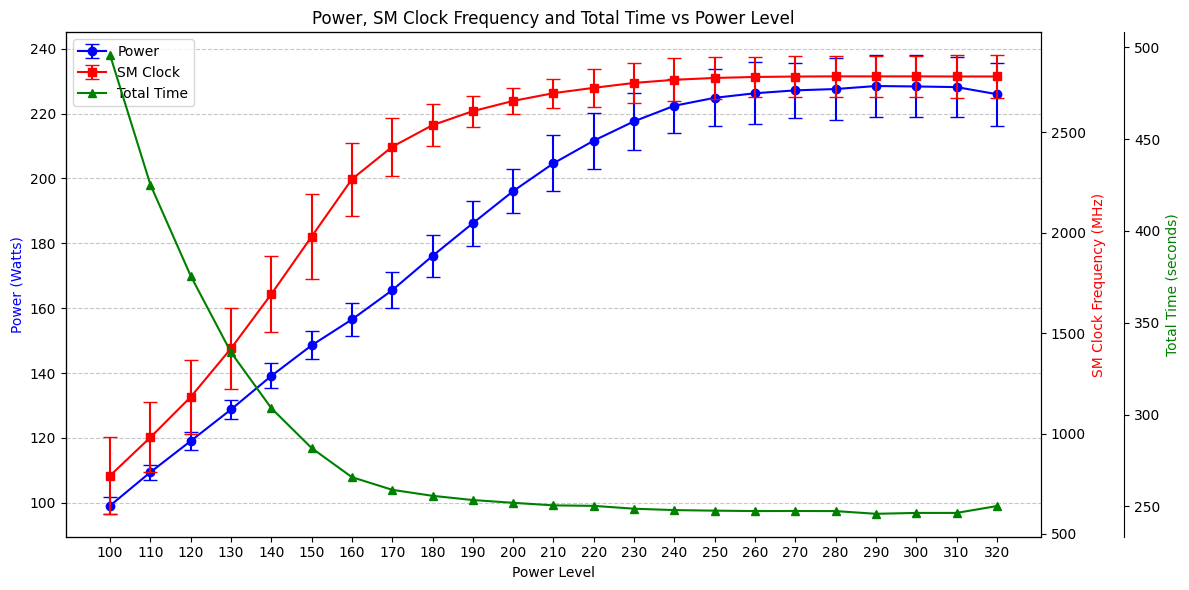

In [53]:
# Create figure with primary and secondary y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

# Offset the right spine of ax3
ax3.spines['right'].set_position(('outward', 60))

# Plot mean power with error bars on primary y-axis
power_line = ax1.errorbar(data_power_freq['power_level'], data_power_freq['mean_power'], 
                         yerr=data_power_freq['std_power'], color='blue', label='Power',
                         marker='o', capsize=5)

# Plot mean SM clock with error bars on secondary y-axis
clock_line = ax2.errorbar(data_power_freq['power_level'], data_power_freq['mean_sm_clock'],
                         yerr=data_power_freq['std_sm_clock'], color='red', label='SM Clock',
                         marker='s', capsize=5)

# Plot total time on third y-axis
time_line = ax3.plot(data_power_freq['power_level'], data_power_freq['total_time'], 
                     color='green', label='Total Time', marker='^')

# Set labels and title
ax1.set_xlabel('Power Level')
ax1.set_ylabel('Power (Watts)', color='blue')
ax2.set_ylabel('SM Clock Frequency (MHz)', color='red')
ax3.set_ylabel('Total Time (seconds)', color='green')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')

# Add title
plt.title('Power, SM Clock Frequency and Total Time vs Power Level')

# Add grids
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [54]:
# energy_data, labeled_energy_data, forward_layer_energy, \
#         to_device, loss, backward, optimize, \
#         to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy = load_data(folder_path)

# # print('forward_layer_energy:', list(eval(forward_layer_energy.iloc[0][0]).keys()))
# print(to_device_energy.shape)

# layer_names, layer_energy = get_layer_energy(forward_layer_energy, folder_path)

# plot_energy_data(labeled_energy_data)
# plot_period_energy_data(labeled_energy_data)
# plot_batch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_step_energy_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_step_energy_distribution_bar(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_epoch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_step_time_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_step_time_distribution_box(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_epoch_step_time(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_layer_energy_batch(layer_names, layer_energy)
# plot_layer_energy_batch_avgstd(layer_names, layer_energy)

In [55]:
# the new dataframe to store the power_level and mean_power 
power_level_actual = data_power_freq[['power_level', 'mean_power']].copy()
print(power_level_actual)

   power_level  mean_power
0          100   99.158886
1          110  109.457902
2          120  119.077929
3          130  128.789580
4          140  139.127732
5          150  148.554049
6          160  156.527213
7          170  165.552747
8          180  176.113972
9          190  186.191018
10         200  196.079237
11         210  204.656544
12         220  211.638040
13         230  217.593700
14         240  222.393954
15         250  224.835210
16         260  226.241937
17         270  227.132724
18         280  227.545570
19         290  228.470528
20         300  228.334223
21         310  228.143062
22         320  225.964017


The parameters of the model: [ 0.00000000e+00  5.01680604e-01  4.43098352e-03 -1.24431877e-05]


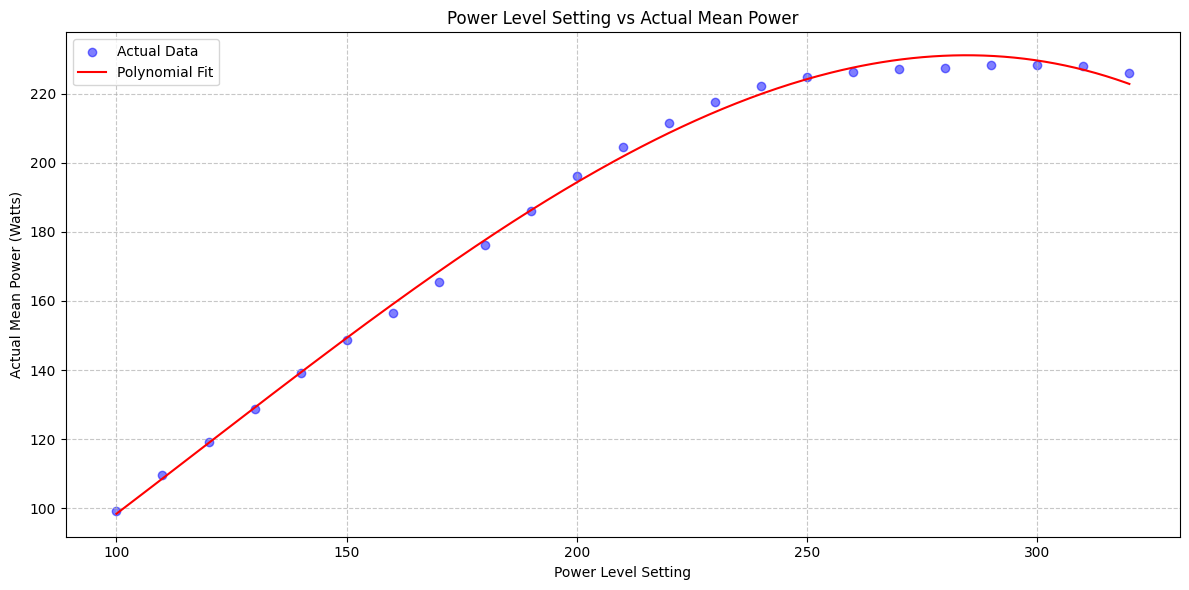

R-squared score: 0.9978


In [56]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np

# Convert power_level to numeric type
X = power_level_actual['power_level'].astype(float).values.reshape(-1, 1)
y = power_level_actual['mean_power'].values

# Create polynomial features (degree=3 for better fitting)
model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
model.fit(X, y)

# Generate points for smooth curve
X_smooth = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_smooth = model.predict(X_smooth)

# print out the parameters of the model
print('The parameters of the model:', model.named_steps['linearregression'].coef_)  # Coefficients

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='blue', label='Actual Data', alpha=0.5)
plt.plot(X_smooth, y_smooth, color='red', label='Polynomial Fit')
plt.xlabel('Power Level Setting')
plt.ylabel('Actual Mean Power (Watts)')
plt.title('Power Level Setting vs Actual Mean Power')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate R-squared score
r2_score = model.score(X, y)
print(f'R-squared score: {r2_score:.4f}')

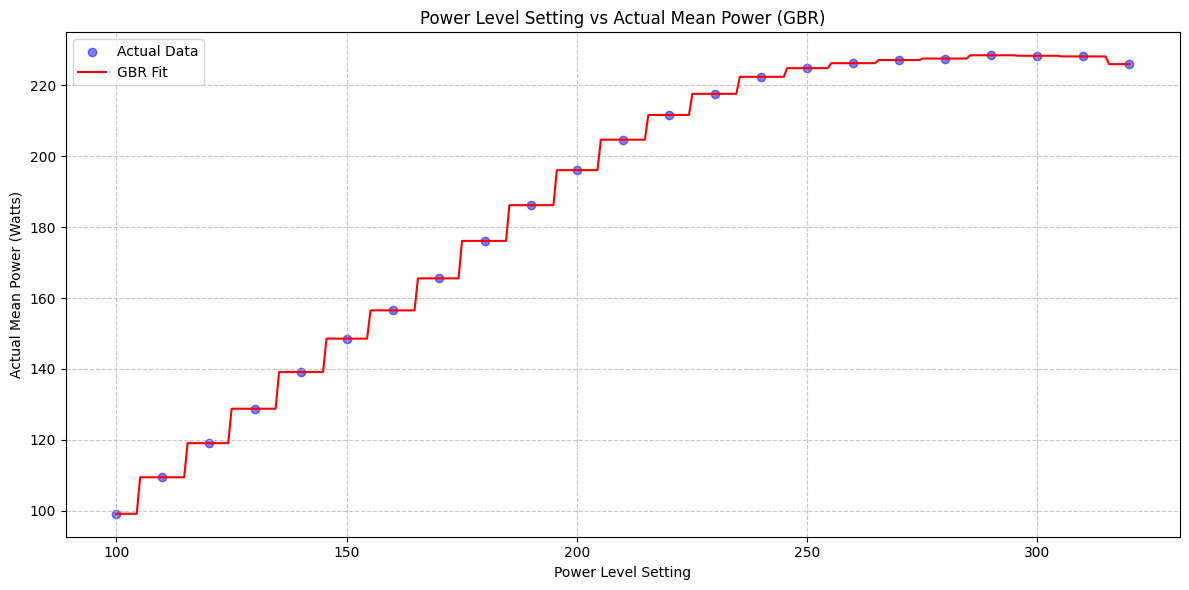

GBR R-squared score: 1.0000
Cross-validation scores: [-4.39494542 -0.7574765  -1.63039753 -4.41922297 -0.03254382]
Mean CV score: -2.2469 (+/- 3.6699)


In [57]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

import matplotlib.pyplot as plt

# Prepare the data
X = power_level_actual['power_level'].astype(float).values.reshape(-1, 1)
y = power_level_actual['mean_power'].values

# Create and train GBR model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gbr.fit(X, y)

# Generate points for smooth curve
X_smooth = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_smooth_gbr = gbr.predict(X_smooth)

# Calculate R-squared score for GBR
r2_score_gbr = gbr.score(X, y)

# Perform cross-validation
cv_scores_gbr = cross_val_score(gbr, X, y, cv=5)

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='blue', label='Actual Data', alpha=0.5)
plt.plot(X_smooth, y_smooth_gbr, color='red', label='GBR Fit')
plt.xlabel('Power Level Setting')
plt.ylabel('Actual Mean Power (Watts)')
plt.title('Power Level Setting vs Actual Mean Power (GBR)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print performance metrics
print(f'GBR R-squared score: {r2_score_gbr:.4f}')
print(f'Cross-validation scores: {cv_scores_gbr}')
print(f'Mean CV score: {cv_scores_gbr.mean():.4f} (+/- {cv_scores_gbr.std() * 2:.4f})')